## Setup & Imports

In [21]:
import sys
sys.path.append('Data/')

In [22]:
# ==== Setup & Imports ====

import os
import string
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.nn import CTCLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

# our modular code
from data_augmentation import get_transforms
from crnn_architectures import (
    CRNN_ResNet18_LSTM,
    CRNN_VGG16_LSTM,
    CRNN_InceptionV1_LSTM,
    CRNN_Adaptive_ResNet_LSTM,
    CRNN_STN_ResNet_LSTM,
    CRNN_Adaptive_STN_ResNet_LSTM,
    VanillaCRNN

)


## Paths & Device

In [ ]:
# ==== Paths & Device ====

TRAIN_IMG_PATH   = '/home/atuin/v123be/v123be36/dataset/part2/train/'
VAL_IMG_PATH     = '/home/atuin/v123be/v123be36/dataset/part2/val/'
MODEL_SAVE_PATH  = 'crnn_captcha_model_vanilla_new_aug.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
torch.backends.cudnn.benchmark = True


Using device: cuda


## Character Set & CTC IDs

In [24]:
# ==== Characters and CTC-blank setup (consistent!) ====

characters = string.digits + string.ascii_uppercase  # '0'..'9','A'..'Z'  => 36 chars
BLANK_ID = len(characters)                            # 36
num_classes = len(characters) + 1                    # 37 (includes CTC-blank)

char_to_int = {c: i for i, c in enumerate(characters)}
int_to_char = {i: c for i, c in enumerate(characters)}
int_to_char[BLANK_ID] = ''  # optional convenience


## Dataset (same API as before)

In [25]:
# ==== Dataset (kept same API) ====

class CaptchaDataset(Dataset):
    """
    Expects:
      img_dir/images/*.png|jpg...
      labels_dir/*.txt (same stem as image)
    Label file lines: "index x_center y_center width height" (we use index only)
    """
    def __init__(self, img_dir, labels_dir, transform=None):
        self.img_dir = img_dir
        self.labels_dir = labels_dir
        self.images = sorted(os.listdir(img_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('L')  # CHANGED: grayscale

        label_name = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(self.labels_dir, label_name)

        label_list = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if parts:
                        label_list.append(int(parts[0]))
        else:
            print(f"Warning: Label file not found for {img_name}")

        label_tensor = torch.tensor(label_list, dtype=torch.long)
        label_length = len(label_list)

        if self.transform:
            image = self.transform(image)

        return image, label_tensor, label_length


## Collate Fn & Quick Visualization

In [26]:
# ==== Collate & Visualization ====

def collate_fn(batch):
    images, labels, label_lengths = zip(*batch)
    max_label_len = max(label_lengths)
    padded_labels = torch.full(
        (len(labels), max_label_len),
        fill_value=BLANK_ID,
        dtype=torch.long
    )
    for i, label in enumerate(labels):
        padded_labels[i, :len(label)] = label
    return torch.stack(images), padded_labels, torch.tensor(label_lengths, dtype=torch.long)

def visualize_batch(images, labels, int_to_char):
    # CHANGED: grayscale stats (match transforms)
    mean = np.array([0.5]).reshape((1, 1, 1))
    std  = np.array([0.5]).reshape((1, 1, 1))

    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    axes = axes.flatten()

    for i in range(min(len(images), len(axes))):
        img_np = images[i].cpu().numpy()
        img_np = img_np * std + mean
        img_np = np.clip(img_np, 0, 1)
        # CHANGED: squeeze channel and show as gray
        if img_np.shape[0] == 1:
            img_np = img_np[0]
            axes[i].imshow(img_np, cmap='gray')
        else:
            img_np = np.transpose(img_np, (1, 2, 0))
            axes[i].imshow(img_np)
        decoded = "".join([int_to_char.get(int(idx), '') for idx in labels[i] if int(idx) != BLANK_ID])
        axes[i].set_title(decoded)
        axes[i].axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


## Transforms (imported)

In [27]:
# ==== Transforms (from data_augmentation.py) ====

train_transform = get_transforms(train=True)
val_transform   = get_transforms(train=False)


## Datasets & Loaders

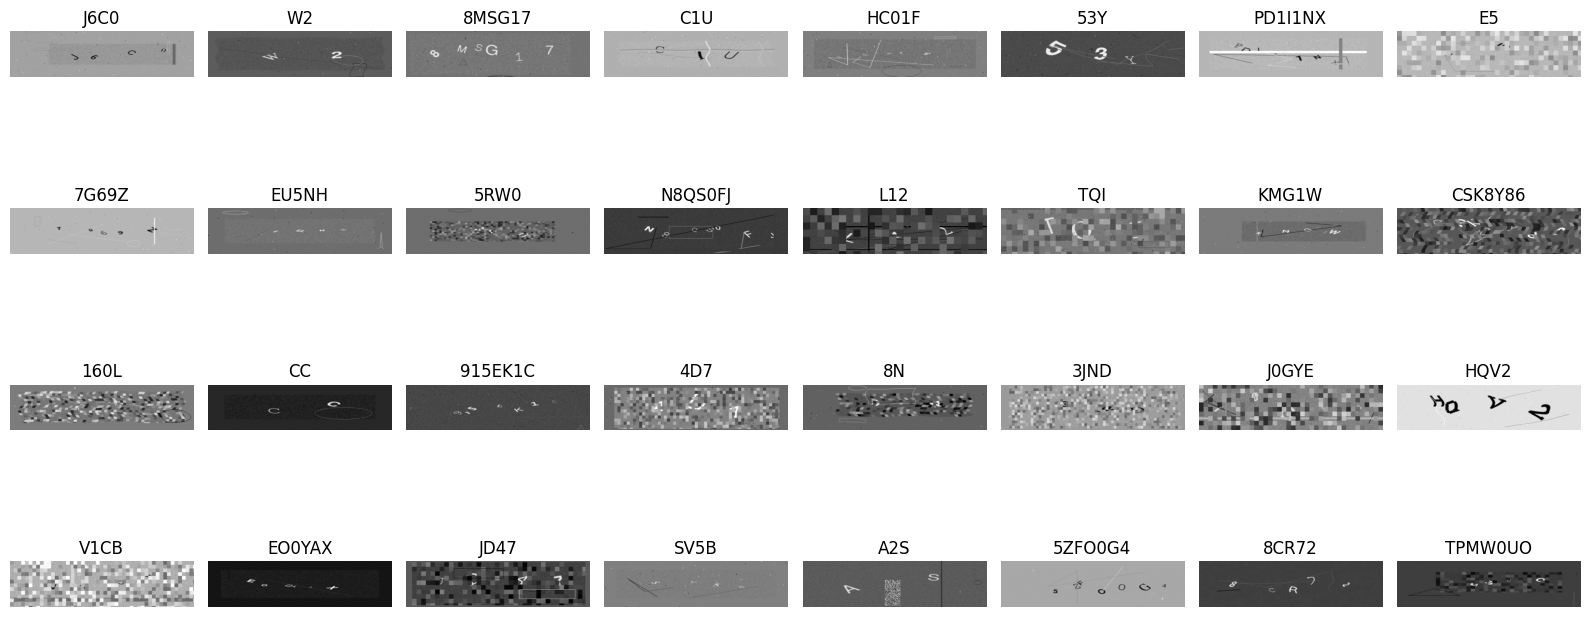

In [28]:
# ==== Datasets & DataLoaders ====

train_dataset = CaptchaDataset(
    os.path.join(TRAIN_IMG_PATH, 'images'),
    os.path.join(TRAIN_IMG_PATH, 'labels'),
    transform=train_transform
)
val_dataset = CaptchaDataset(
    os.path.join(VAL_IMG_PATH, 'images'),
    os.path.join(VAL_IMG_PATH, 'labels'),
    transform=val_transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          collate_fn=collate_fn, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,
                        collate_fn=collate_fn, num_workers=4, pin_memory=True)

# (Optional) peek
if len(train_loader) > 0:
    sample_images, sample_labels, _ = next(iter(train_loader))
    visualize_batch(sample_images, sample_labels, int_to_char)


## Choose a Model (plug & play)

In [35]:
# ==== Model Selection ====
# Pick ONE:

# Baselines (all backbones were already patched to accept 1-ch)
#model = CRNN_ResNet18_LSTM(num_classes=num_classes).to(device)

# model = CRNN_VGG16_LSTM(num_classes=num_classes).to(device)

# model = CRNN_InceptionV1_LSTM(num_classes=num_classes).to(device)

#Vanilla CNN
model = VanillaCRNN(num_classes =num_classes).to(device)

# With feature refinement (Adaptive)
#model = CRNN_Adaptive_ResNet_LSTM(num_classes=num_classes).to(device)

# With spatial transformer (STN)
#model = CRNN_STN_ResNet_LSTM(num_classes=num_classes).to(device)  # CHANGED: remove stn_in_channels

# With both (STN + Adaptive)
#model = CRNN_Adaptive_STN_ResNet_LSTM(num_classes=num_classes).to(device)  # CHANGED: remove stn_in_channels

print(sum(p.numel() for p in model.parameters())/1e6, "M params")


4.875722 M params


## Loss, Optimizer, Scheduler

In [ ]:
# ==== Loss / Optimizer / Scheduler ====

criterion = CTCLoss(blank=BLANK_ID, zero_infinity=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

num_epochs = 100
best_loss = float('inf')
start_epoch = 0

WARM_START = True  # True: load only model weights; False: strict resume if checkpoint exists


## (Optional) Load Checkpoint

In [37]:
# ==== Checkpoint Load (optional) ====

if os.path.exists(MODEL_SAVE_PATH):
    try:
        ckpt = torch.load(MODEL_SAVE_PATH, map_location=device)
    except:
        pass

    model.load_state_dict(ckpt['model_state_dict'])
    print("Loaded model weights from checkpoint.")

    if WARM_START:
        best_loss = float('inf')
        start_epoch = 0
        print("Warm start: NOT resuming epoch/optimizer/scheduler.")
    else:
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        scheduler.load_state_dict(ckpt['scheduler_state_dict'])
        best_loss = ckpt.get('best_loss', float('inf'))
        start_epoch = ckpt.get('epoch', 0)
        print(f"Strict resume: starting from epoch {start_epoch}, best loss {best_loss:.4f}")
else:
    print("No saved model found, starting training from scratch.")


Loaded model weights from checkpoint.
Warm start: NOT resuming epoch/optimizer/scheduler.


/tmp/ipykernel_3977475/3978749240.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(MODEL_SAVE_PATH, map_location=device)


## Training + Validation (per epoch)

In [38]:
# ==== Training & Validation Loops ====

for epoch in range(start_epoch, num_epochs):
    # --- Train ---
    model.train()
    running_loss = 0.0

    for images, labels, label_lengths in train_loader:
        images = images.to(device)
        labels = labels.to(device, dtype=torch.long)
        label_lengths = label_lengths.to(device, dtype=torch.long)

        optimizer.zero_grad()

        logits_seq, _, _, _ = model(images)   # (T,B,K)
        T, B, _ = logits_seq.shape
        input_lengths = torch.full((B,), T, dtype=torch.long, device=device)

        loss = criterion(logits_seq.log_softmax(2), labels, input_lengths, label_lengths)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / max(1, len(train_loader))
    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f}')

    # --- Validate ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels, label_lengths in val_loader:
            images = images.to(device)
            labels = labels.to(device, dtype=torch.long)
            label_lengths = label_lengths.to(device, dtype=torch.long)

            logits_seq, _, _, _ = model(images)
            T, B, _ = logits_seq.shape
            input_lengths = torch.full((B,), T, dtype=torch.long, device=device)

            loss = criterion(logits_seq.log_softmax(2), labels, input_lengths, label_lengths)
            val_loss += loss.item()

    avg_val_loss = val_loss / max(1, len(val_loader))
    print(f'Validation Loss: {avg_val_loss:.4f}')

    scheduler.step(avg_val_loss)

    # --- Save Best ---
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_loss': best_loss,
        }, MODEL_SAVE_PATH)
        print(f'Model saved! Validation loss improved to {best_loss:.4f}')


## Decoding Helpers (CTC Greedy)

In [39]:
# ==== Decoding Helpers (CTC Greedy + Beam) ====

def _extract_logits_seq(outputs):
    # Accept either (T,B,C) or model tuple
    return outputs[0] if isinstance(outputs, tuple) else outputs

def ctc_greedy_decode(outputs, int_to_char, blank_id: int):
    logits_seq = _extract_logits_seq(outputs)     # (T,B,K)
    with torch.no_grad():
        best_path = logits_seq.log_softmax(2).argmax(2)  # (T,B)
        best_path = best_path.transpose(0, 1)            # (B,T)
    decoded = []
    for seq in best_path:
        prev = None
        chars = []
        for p in seq.tolist():
            if p != blank_id and p != prev:  # collapse repeats then drop blanks
                chars.append(int_to_char.get(p, ''))
            prev = p
        decoded.append(''.join(chars))
    return decoded

# NEW: lightweight prefix beam search (no external deps)
def ctc_beam_search_decode(outputs, int_to_char, blank_id: int, beam_width: int = 5):
    """
    Outputs: (T,B,K) logits; returns list[str] length B.
    Simple prefix beam search with log probs, blank handling, no LM.
    """
    logits_seq = _extract_logits_seq(outputs)  # (T,B,K)
    T, B, K = logits_seq.shape
    logp = logits_seq.log_softmax(2)          # (T,B,K)

    results = []
    for b in range(B):
        # beam: dict[prefix(str)] -> (p_blank, p_nonblank) in log-space
        beam = { "": (0.0, -float('inf')) }   # log(1)=0, log(0)=-inf

        for t in range(T):
            next_beam = {}
            for prefix, (pb, pnb) in beam.items():
                # prob of staying at prefix via blank
                p_blank_t = pb + float(logp[t, b, blank_id].item())
                _merge(next_beam, prefix, p_blank_t, True)

                # extend with characters
                for c in range(K):
                    if c == blank_id: 
                        continue
                    p_t = float(logp[t, b, c].item())

                    last = prefix[-1] if prefix else None
                    new_prefix = prefix

                    if last == int_to_char.get(c, None):
                        # repeated char without blank in between
                        # stay in same prefix but go to nonblank
                        p_repeat = pnb + p_t
                        _merge(next_beam, new_prefix, p_repeat, False)
                    else:
                        # append new char
                        ch = int_to_char.get(c, '')
                        if not ch:
                            continue
                        new_prefix = prefix + ch
                        p_new = (pb + p_t)  # coming from blank
                        _merge(next_beam, new_prefix, p_new, False)

            # prune
            beam = _topk_beam(next_beam, beam_width)

        # pick best by logsumexp of (pb,pnb)
        best_pref, (pb, pnb) = max(beam.items(), key=lambda kv: _logsumexp2(*kv[1]))
        results.append(best_pref)
    return results

def _merge(beam, prefix, logp, is_blank):
    pb, pnb = beam.get(prefix, (-float('inf'), -float('inf')))
    if is_blank:
        pb = _logsumexp2(pb, logp)
    else:
        pnb = _logsumexp2(pnb, logp)
    beam[prefix] = (pb, pnb)

def _topk_beam(beam, k):
    # rank by joint probability logsumexp(pb, pnb)
    items = sorted(beam.items(), key=lambda kv: _logsumexp2(*kv[1]), reverse=True)
    return dict(items[:k])

def _logsumexp2(a, b):
    m = max(a, b)
    if m == -float('inf'): 
        return m
    return m + math.log(math.exp(a - m) + math.exp(b - m))

def decode_labels(labels, label_lengths, int_to_char, blank_id: int):
    labels = labels.cpu()
    label_lengths = label_lengths.cpu()
    decoded = []
    if labels.dim() == 2:  # padded (B, max_L)
        for y, L in zip(labels, label_lengths):
            L = int(L.item())
            toks = [t for t in y[:L].tolist() if t != blank_id]
            decoded.append(''.join(int_to_char.get(t, '') for t in toks))
    else:  # concatenated form (not used here, but safe)
        idx = 0
        for L in label_lengths.tolist():
            L = int(L)
            toks = labels[idx:idx+L].tolist()
            decoded.append(''.join(int_to_char.get(t, '') for t in toks))
            idx += L
    return decoded


In [ ]:
def ctc_greedy_decode_capped(outputs, int_to_char, blank_id: int, max_len: int = 10):
    """
    Batch greedy CTC decode with a hard cap on emitted characters.
    Returns: List[str] of length B.
    """
    logits_seq = _extract_logits_seq(outputs)     # (T,B,K) or tuple->(T,B,K)
    with torch.no_grad():
        best_path = logits_seq.log_softmax(2).argmax(2)  # (T,B)
        best_path = best_path.transpose(0, 1)            # (B,T)

    decoded = []
    for seq in best_path:
        prev = blank_id
        out_ids = []
        for p in seq.tolist():
            if p != blank_id and p != prev:
                out_ids.append(p)
                if len(out_ids) >= max_len:
                    break
            prev = p
        decoded.append(''.join(int_to_char.get(i, '') for i in out_ids))
    return decoded


## Final Evaluation (CER & Seq Acc)

In [ ]:
# ==== Final Evaluation on Validation Set ====

USE_BEAM_AT_EVAL = False   # NEW: set False to fall back to greedy
BEAM_WIDTH = 5            # NEW: typical 3–10

def _levenshtein(a: str, b: str) -> int:
    # standard DP with rolling array
    n, m = len(a), len(b)
    if n < m:
        # ensure b is the shorter row if you prefer, but not required
        a, b = b, a
        n, m = m, n
    prev = list(range(m + 1))
    for i in range(1, n + 1):
        cur0 = i
        prev_diag = i - 1  # value of prev[j-1] from previous iteration
        for j in range(1, m + 1):
            temp = prev[j]
            cost = 0 if a[i - 1] == b[j - 1] else 1
            # substitution (prev_diag), insertion (cur0 -> left), deletion (prev[j] -> up)
            cur0 = min(prev_diag + cost,            # substitute / match
                       cur0 + 1,                     # insert
                       prev[j] + 1)                  # delete
            prev_diag = temp
            prev[j] = cur0
        prev[0] = i
    return prev[m]

model.eval()
total_samples = 0
correct_predictions = 0
total_edits = 0
total_chars = 0

with torch.no_grad():
    for images, labels, label_lengths in val_loader:
        images = images.to(device)
        labels = labels.to(device, dtype=torch.long)
        label_lengths = label_lengths.to(device, dtype=torch.long)

        outputs = model(images)

        if USE_BEAM_AT_EVAL:
            decoded_preds  = ctc_beam_search_decode(outputs, int_to_char=int_to_char, blank_id=BLANK_ID, beam_width=BEAM_WIDTH)  # CHANGED
            decoded_preds = [s[:10] for s in decoded_preds]
        else:
            decoded_preds = ctc_greedy_decode_capped(
                    outputs, int_to_char=int_to_char, blank_id=BLANK_ID, max_len=10
            )
        decoded_labels = decode_labels(labels, label_lengths, int_to_char=int_to_char, blank_id=BLANK_ID)

        for pred, truth in zip(decoded_preds, decoded_labels):
            if pred == truth:
                correct_predictions += 1
            total_samples += 1
            total_edits += _levenshtein(pred, truth)
            total_chars += len(truth)

seq_accuracy = 100.0 * correct_predictions / max(1, total_samples)
cer = (total_edits / total_chars) if total_chars > 0 else 0.0
print(f"\nCharacter Error Rate (CER): {cer:.4f}")
print(f"Sequence Accuracy: {seq_accuracy:.2f}%")



Character Error Rate (CER): 0.1348
Sequence Accuracy: 54.06%


## Error Analysis (Top Confusions)

In [ ]:
# ==== Error Analysis (optional but useful) ====

from collections import Counter, defaultdict

idx_to_char = {i: c for i, c in enumerate(characters)}  # 0..35
char_to_idx = {c: i for i, c in enumerate(characters)}
V = len(characters)  # 36

def levenshtein_backtrace(a: str, b: str):
    n, m = len(a), len(b)
    dp = [[0]*(m+1) for _ in range(n+1)]
    bt = [[None]*(m+1) for _ in range(n+1)]

    for i in range(1, n+1):
        dp[i][0] = i
        bt[i][0] = ('del', a[i-1], None)
    for j in range(1, m+1):
        dp[0][j] = j
        bt[0][j] = ('ins', None, b[j-1])

    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = 0 if a[i-1] == b[j-1] else 1
            choices = [
                (dp[i-1][j] + 1, ('del', a[i-1], None)),
                (dp[i][j-1] + 1, ('ins', None, b[j-1])),
                (dp[i-1][j-1] + cost,
                 ('eq' if cost == 0 else 'sub', a[i-1], b[j-1]))
            ]
            dp[i][j], bt[i][j] = min(choices, key=lambda x: x[0])

    ops = []
    i, j = n, m
    while i > 0 or j > 0:
        op = bt[i][j]
        ops.append(op)
        t = op[0]
        if t in ('eq', 'sub'):
            i -= 1; j -= 1
        elif t == 'del':
            i -= 1
        elif t == 'ins':
            j -= 1
    ops.reverse()
    return ops

conf_mat = np.zeros((V, V), dtype=np.int64)  # truth row -> pred col (subs only)
sub_counter = Counter()
ins_counter = Counter()
del_counter = Counter()
truth_support = Counter()
correct_support = Counter()

model.eval()
with torch.no_grad():
    for images, labels, label_lengths in val_loader:
        images = images.to(device)
        labels = labels.to(device, dtype=torch.long)
        label_lengths = label_lengths.to(device, dtype=torch.long)

        outputs = model(images)
        preds  = ctc_greedy_decode_capped(
            outputs, int_to_char=int_to_char, blank_id=BLANK_ID, max_len=10
        )
        truths = decode_labels(labels, label_lengths, int_to_char=int_to_char, blank_id=BLANK_ID)

        # if USE_BEAM_AT_EVAL:
        #     decoded_preds  = ctc_beam_search_decode(outputs, int_to_char=int_to_char, blank_id=BLANK_ID, beam_width=BEAM_WIDTH)  # CHANGED
        # else:
        #     decoded_preds  = ctc_greedy_decode(outputs, int_to_char=int_to_char, blank_id=BLANK_ID)

        # decoded_labels = decode_labels(labels, label_lengths, int_to_char=int_to_char, blank_id=BLANK_ID)


        for truth, pred in zip(truths, preds):
            for ch in truth:
                truth_support[ch] += 1

            for op, a_ch, b_ch in levenshtein_backtrace(truth, pred):
                if op == 'eq':
                    correct_support[a_ch] += 1
                elif op == 'sub':
                    sub_counter[(a_ch, b_ch)] += 1
                    if a_ch in char_to_idx and b_ch in char_to_idx:
                        conf_mat[char_to_idx[a_ch], char_to_idx[b_ch]] += 1
                elif op == 'ins':
                    ins_counter[b_ch] += 1
                elif op == 'del':
                    del_counter[a_ch] += 1

def safe_rate(num, den):
    return (num / den) if den > 0 else 0.0

per_char_error = []
for ch in characters:
    subs_from_ch = sum(cnt for (t,p), cnt in sub_counter.items() if t == ch)
    dels_of_ch   = del_counter[ch]
    total_err    = subs_from_ch + dels_of_ch
    per_char_error.append((ch, total_err, truth_support[ch], safe_rate(total_err, truth_support[ch])))

per_char_error.sort(key=lambda x: x[3], reverse=True)

print("\n=== Top 15 most error-prone characters (by error rate) ===")
print("char  errors  support  error_rate")
for ch, err, sup, rate in per_char_error[:15]:
    print(f"{ch:>3}  {err:>6}  {sup:>7}   {rate:6.3f}")

print("\n=== Top 20 substitution confusions (truth -> pred) ===")
for (t, p), cnt in sub_counter.most_common(20):
    print(f"{t} -> {p}: {cnt}")

print("\n=== Top 10 insertions (spurious preds) ===")
for ch, cnt in ins_counter.most_common(10):
    print(f"+{ch}: {cnt}")

print("\n=== Top 10 deletions (missed truth chars) ===")
for ch, cnt in del_counter.most_common(10):
    print(f"-{ch}: {cnt}")

row_sums = conf_mat.sum(axis=1, keepdims=True)
norm_conf = np.divide(conf_mat, np.maximum(row_sums, 1), where=row_sums>0)

pairs = []
for i in range(V):
    for j in range(V):
        if i == j: continue
        if row_sums[i, 0] > 0 and conf_mat[i, j] > 0:
            pairs.append(((idx_to_char[i], idx_to_char[j]), norm_conf[i, j], conf_mat[i, j], int(row_sums[i, 0])))
pairs.sort(key=lambda x: x[1], reverse=True)
print("\n=== Worst normalized substitutions (row-normalized) ===")
for (t, p), frac, raw, row_total in pairs[:15]:
    print(f"{t} -> {p}: frac={frac:.3f}  count={raw}  (subs from '{t}' total={row_total})")



=== Top 15 most error-prone characters (by error rate) ===
char  errors  support  error_rate
  O    1187     2101    0.565
  Q     654     2097    0.312
  1    1164     4405    0.264
  K     455     2265    0.201
  Y     336     2011    0.167
  R     341     2081    0.164
  X     321     2059    0.156
  D     369     2407    0.153
  F     343     2297    0.149
  A     334     2424    0.138
  V     276     2026    0.136
  T     290     2134    0.136
  H     295     2194    0.134
  G     302     2247    0.134
  I     284     2186    0.130

=== Top 20 substitution confusions (truth -> pred) ===
O -> 0: 1000
1 -> 7: 526
Q -> 0: 269
1 -> I: 196
G -> 6: 175
D -> 0: 153
K -> X: 146
R -> P: 125
Q -> 8: 113
9 -> S: 112
U -> 0: 96
C -> G: 94
6 -> S: 90
A -> 4: 87
X -> M: 79
F -> P: 76
7 -> 1: 73
K -> N: 66
1 -> 2: 61
T -> I: 60

=== Top 10 insertions (spurious preds) ===
+0: 130
+S: 43
+2: 40
+7: 29
+G: 27
+C: 26
+6: 26
+3: 24
+1: 17
+P: 14

=== Top 10 deletions (missed truth chars) ===
-I: 186

## Inference Example

In [ ]:
# ==== Quick Inference Example ====

def predict_images(image_paths, transform=val_transform, use_beam=True, beam_width=5):
    imgs = []
    for p in image_paths:
        img = Image.open(p).convert('L')  # CHANGED: grayscale
        imgs.append(transform(img))
    batch = torch.stack(imgs).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(batch)
        if use_beam:
            preds = ctc_beam_search_decode(outputs, int_to_char=int_to_char, blank_id=BLANK_ID, beam_width=beam_width)  # NEW
            preds = [s[:10] for s in preds]
        else:
            preds = ctc_greedy_decode_capped(
            outputs, int_to_char=int_to_char, blank_id=BLANK_ID, max_len=10
            )

    return preds


# Example:
# test_paths = [
#     '/path/to/sample1.png',
#     '/path/to/sample2.png'
# ]
# print(predict_images(test_paths))


# Save Test Data

In [ ]:
import torch
import json
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
from PIL import Image
import os

# --- Dataset class (no labels) ---
class TestCaptchaDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.images = sorted(os.listdir(img_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("L")  # grayscale like training

        if self.transform:
            image = self.transform(image)

        return image, os.path.splitext(img_name)[0], img_path  # (tensor, id, path)


# --- Your character set ---
import string
characters = string.digits + string.ascii_uppercase   # "0-9A-Z" = 36 chars
BLANK_ID = len(characters)                            # 36
num_classes = len(characters) + 1                     # 37

char_to_int = {c: i for i, c in enumerate(characters)}
int_to_char = {i: c for i, c in enumerate(characters)}
int_to_char[BLANK_ID] = ''  # blank


# --- Greedy CTC decoder ---
def ctc_greedy_decode(logits):
    """
    logits: [batch, seq_len, num_classes]
    returns: list of decoded strings
    """
    preds = logits.argmax(dim=2).cpu().numpy()
    decoded = []
    for seq in preds:
        string = []
        prev = None
        for idx in seq:
            if idx != prev and idx != BLANK_ID:  # remove repeats + blanks
                string.append(int_to_char[idx])
            prev = idx
        decoded.append("".join(string))
    return decoded


# --- Test loaders (images folder inside test dirs) ---
test_dirs = [
    "/home/atuin/v123be/v123be36/dataset/part2/test/images/",
    "/home/atuin/v123be/v123be36/dataset/part3/test/images/",
    "/home/atuin/v123be/v123be36/dataset/part4/test/images/"
]

transform = transforms.Compose([
    transforms.Resize((160, 640)),  # adapt to your model input
    transforms.ToTensor()
])

all_datasets = [TestCaptchaDataset(d, transform=val_transform) for d in test_dirs]
test_dataset = ConcatDataset(all_datasets)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# --- Inference ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

results = []

with torch.no_grad():
    for images, image_ids, img_paths in test_loader:
        images = images.to(device)

        outputs = model(images)
        logits = outputs[0] if isinstance(outputs, tuple) else outputs  # take logits

        captcha_strings = ctc_greedy_decode(logits)

        for captcha_string, image_id, path in zip(captcha_strings, image_ids, img_paths):
            with Image.open(path) as img:
                width, height = img.size

            results.append({
                "height": height,
                "width": width,
                "image_id": image_id,
                "captcha_string": captcha_string,
                "annotations": []
            })

# --- Save predictions ---
with open("predictions_vanilla_new.json", "w") as f:
    json.dump(results, f, indent=4)

print(f"Saved {len(results)} predictions to predictions.json")


Saved 60000 predictions to predictions.json


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
import os

# --- Folder containing test images ---
img_dir = "/home/atuin/v123be/v123be36/dataset/part2/test/images/"  # change as needed

# --- Pick 10 random images ---
all_images = sorted(os.listdir(img_dir))
sample_images = random.sample(all_images, 10)

# --- Transform (same as during inference) ---
transform = transforms.Compose([
    transforms.Resize((160, 640)),
    transforms.ToTensor()
])

# --- Prepare images for model ---
images = []
img_paths = []
for img_name in sample_images:
    img_path = os.path.join(img_dir, img_name)
    img = Image.open(img_path).convert("L")
    img_tensor = transform(img)
    images.append(img_tensor)
    img_paths.append(img_path)

images = torch.stack(images).to(device)  # batch

# --- Inference ---
model.eval()
with torch.no_grad():
    outputs = model(images)
    logits = outputs[0] if isinstance(outputs, tuple) else outputs
    captcha_strings = ctc_greedy_decode(logits)

# --- Plot images with predictions ---
plt.figure(figsize=(20, 6))
for i, (img_path, pred) in enumerate(zip(img_paths, captcha_strings), 1):
    img = Image.open(img_path)
    plt.subplot(2, 5, i)
    plt.imshow(img, cmap="gray")
    plt.title(f"Pred: {pred}", fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()
